In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
print('Done')

Done


### Exploring the Data

In [2]:
df = pd.read_csv('air_quality.csv')

In [3]:
df.head()

,year,month,day,hour,PM2.5,temperature,pressure,rain,wind_direction,wind_speed
0,2013,3,1,0,4.0,-0.7,1023.0,0.0,NNW,4.4
1,2013,3,1,1,8.0,-1.1,1023.2,0.0,N,4.7
2,2013,3,1,2,7.0,-1.1,1023.5,0.0,NNW,5.6
3,2013,3,1,3,6.0,-1.4,1024.5,0.0,NW,3.1
4,2013,3,1,4,3.0,-2.0,1025.2,0.0,N,2.0


In [4]:
df.describe()

,year,month,day,hour,PM2.5,temperature,pressure,rain,wind_speed
count,35064.000000,35064.000000,35064.000000,35064.000000,34139.000000,35044.000000,35044.000000,35044.000000,35050.000000
mean,2014.662560,6.522930,15.729637,11.500000,75.405703,13.584607,1011.846920,0.067421,1.708496
std,1.177213,3.448752,8.800218,6.922285,79.954493,11.399097,10.404047,0.910056,1.204071
min,2013.000000,1.000000,1.000000,0.000000,-1.000000,-16.800000,985.900000,0.000000,0.000000
25%,2014.000000,4.000000,8.000000,5.750000,17.000000,3.100000,1003.300000,0.000000,0.900000
50%,2015.000000,7.000000,16.000000,11.500000,51.000000,14.500000,1011.400000,0.000000,1.400000
75%,2016.000000,10.000000,23.000000,17.250000,106.000000,23.300000,1020.100000,0.000000,2.200000
max,2017.000000,12.000000,31.000000,23.000000,898.000000,40.500000,1042.000000,72.500000,11.200000


In [5]:
df_ = df[df['PM2.5']!=-1.0]
df_.shape

(32452, 10)

In [6]:
df_.corr().loc['PM2.5']

year          -0.057626
month          0.018978
day            0.021385
hour          -0.011680
PM2.5          1.000000
temperature   -0.121541
pressure      -0.004737
rain          -0.012758
wind_speed    -0.268804
Name: PM2.5, dtype: float64

In [7]:
df_.isna().sum()

year                0
month               0
day                 0
hour                0
PM2.5             925
temperature        11
pressure           11
rain               11
wind_direction     43
wind_speed         10
dtype: int64

In [8]:
df_.dropna(inplace=True)

H:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


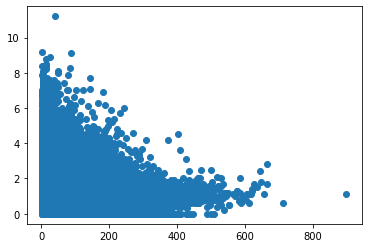

In [9]:
plt.scatter(df_['PM2.5'],df_['wind_speed'])

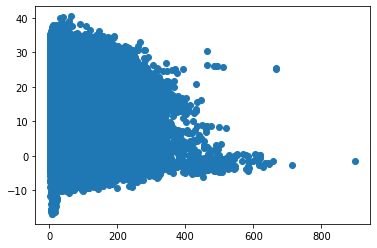

In [10]:
plt.scatter(df_['PM2.5'],df_['temperature'])

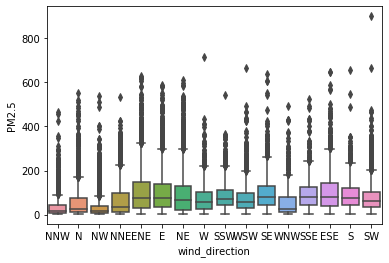

In [11]:
sns.boxplot(x='wind_direction',y='PM2.5',data=df_)

### Creating Dummies

In [12]:
df_hg = df_.groupby(['hour']).mean()
df_mg = df_.groupby(['month']).mean()
df_dg = df_.groupby(['day']).mean()
df_yg = df.groupby('year').mean()

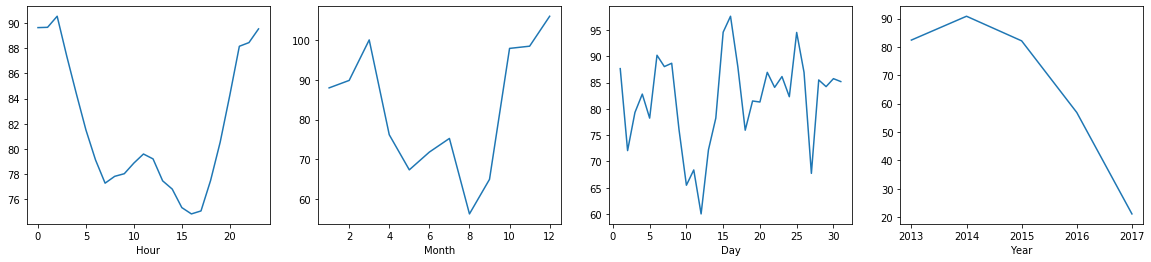

In [13]:
fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(20,4))
dfs = [df_hg,df_mg,df_dg,df_yg]
labels = ['Hour','Month','Day','Year']
for i in range(4):
    axes[i].plot(dfs[i]['PM2.5'])
    axes[i].set_xlabel(labels[i])

In [14]:
month_dummies = pd.get_dummies(df_['month'])
month_dummies = month_dummies.rename(columns = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})
df_ = pd.merge(df_,month_dummies,left_index=True,right_index=True)
year_dummies = pd.get_dummies(df_['year'])
df_ = pd.merge(df_,year_dummies,left_index=True,right_index=True)
hour_dummies = pd.get_dummies(df_['hour'])
df_=pd.merge(df_,hour_dummies,left_index=True,right_index=True)
wd_dummies = pd.get_dummies(df_['wind_direction'])
df_ = pd.merge(df_,wd_dummies,left_index=True,right_index=True)

months = list(month_dummies.columns)
years = list(year_dummies.columns)
hours = list(hour_dummies.columns)
wind_directions = list(wd_dummies.columns)

In [15]:
for i in df_.index:
    if i < 6:
        df_['PM2.5_6hr'] = np.nan
    else:
        df_.loc[i,'PM2.5_6hr'] = df['PM2.5'][i-6:i].mean()

In [16]:
for i in df_.index:
    if i < 12:
        df_['PM2.5_12hr'] = np.nan
    else:
        df_.loc[i,'PM2.5_12hr'] = df['PM2.5'][i-12:i].mean()

In [17]:
for i in df_.index:
    if i < 24:
        df_['PM2.5_24hr'] = np.nan
    else:
        df_.loc[i,'PM2.5_24hr'] = df['PM2.5'][i-24:i].mean()

In [18]:
df_.dropna(inplace=True)

In [19]:
pr = PolynomialFeatures(2)
temp_pr = pr.fit_transform(df_[['temperature']])
ws_pr = pr.fit_transform(df_[['wind_speed']])
df_temp = pd.DataFrame(temp_pr)
df_ws = pd.DataFrame(ws_pr)
df_temp.columns = 't0 t1 t2'.split()
df_ws.columns = 'ws0 ws1 ws2'.split()
df_ = pd.merge(df_,df_temp,left_index=True,right_index=True)
df_ = pd.merge(df_,df_ws,left_index=True,right_index=True)
df_.head()

,year,month,day,hour,PM2.5,temperature,pressure,rain,wind_direction,wind_speed,...,WSW,PM2.5_6hr,PM2.5_12hr,PM2.5_24hr,t0,t1,t2,ws0,ws1,ws2
24,2013,3,2,0,22.0,-0.4,1031.0,0.0,ENE,1.4,...,0,13.500000,10.000000,7.125,1.0,-1.4,1.96,1.0,1.2,1.44
25,2013,3,2,1,14.0,-1.0,1031.3,0.0,NNE,1.1,...,0,15.333333,11.583333,7.875,1.0,-2.0,4.00,1.0,1.2,1.44
26,2013,3,2,2,13.0,-1.5,1030.9,0.0,E,1.7,...,0,16.333333,12.500000,8.125,1.0,-2.8,7.84,1.0,1.4,1.96
27,2013,3,2,3,3.0,-1.4,1030.6,0.0,NNE,1.4,...,0,16.666667,13.083333,8.375,1.0,-2.6,6.76,1.0,1.2,1.44
28,2013,3,2,4,3.0,-1.5,1030.8,0.0,NNW,0.9,...,0,15.166667,12.666667,8.250,1.0,-4.3,18.49,1.0,0.9,0.81


### Training the Model

In [31]:
X_cols = ['pressure','rain']+months+hours+years+wind_directions+['temperature','wind_speed']+['PM2.5_6hr','PM2.5_12hr','PM2.5_24hr']
y_col = ['PM2.5']
X,y = df_[X_cols],df_[y_col]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30)

In [32]:
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Validating the Model

In [34]:
y_hat_train = lm.predict(X_train)
mse_tran = mean_squared_error(y_train,y_hat_train)
mse_tran**0.5

32.64315640400205

In [22]:
y_hat = lm.predict(X_test)
mse = mean_squared_error(y_test,y_hat)
print(mse**0.5)

33.931480718353896


### Predicting with the Model

In [23]:
df_pred = df[df['PM2.5']==-1.0]
print(len(df_pred))

2612


In [24]:
df_pred.dropna(inplace=True)

H:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
df_pred.shape

(2569, 10)

In [26]:
month_dummies = pd.get_dummies(df_pred['month'])
month_dummies = month_dummies.rename(columns = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})
df_pred = pd.merge(df_pred,month_dummies,left_index=True,right_index=True)
year_dummies = pd.get_dummies(df_pred['year'])
df_pred = pd.merge(df_pred,year_dummies,left_index=True,right_index=True)
hour_dummies = pd.get_dummies(df_pred['hour'])
df_pred =pd.merge(df_pred,hour_dummies,left_index=True,right_index=True)
wd_dummies = pd.get_dummies(df_pred['wind_direction'])
df_pred = pd.merge(df_pred,wd_dummies,left_index=True,right_index=True)

months = list(month_dummies.columns)
years = list(year_dummies.columns)
hours = list(hour_dummies.columns)
wind_directions = list(wd_dummies.columns)

for i in df_pred.index:
    df_pred.loc[i,'PM2.5_6hr'] = df['PM2.5'][i-6:i].mean()
        
for i in df_pred.index:
    df_pred.loc[i,'PM2.5_12hr'] = df['PM2.5'][i-12:i].mean()
        
for i in df_pred.index:
    df_pred.loc[i,'PM2.5_24hr'] = df['PM2.5'][i-24:i].mean()

In [27]:
df_pred.head(20)

,year,month,day,hour,PM2.5,temperature,pressure,rain,wind_direction,wind_speed,...,SE,SSE,SSW,SW,W,WNW,WSW,PM2.5_6hr,PM2.5_12hr,PM2.5_24hr
30021,2016,8,2,21,-1.0,30.6,1005.2,0.0,S,1.3,...,0,0,0,0,0,0,0,27.666667,34.000000,64.681818
30083,2016,8,5,11,-1.0,31.1,1006.2,0.0,ENE,2.2,...,0,0,0,0,0,0,0,74.500000,63.583333,90.833333
30084,2016,8,5,12,-1.0,31.5,1005.9,0.0,ESE,2.2,...,0,0,0,0,0,0,0,62.333333,57.583333,84.416667
30100,2016,8,6,4,-1.0,26.8,1002.9,0.0,SW,0.2,...,0,0,0,1,0,0,0,106.833333,83.083333,69.000000
30106,2016,8,6,10,-1.0,30.8,1002.4,0.0,ENE,1.1,...,0,0,0,0,0,0,0,103.000000,104.916667,75.875000
30128,2016,8,7,8,-1.0,24.0,1004.5,3.2,ENE,2.1,...,0,0,0,0,0,0,0,15.833333,38.250000,67.416667
30140,2016,8,7,20,-1.0,29.6,1004.6,0.0,S,0.9,...,0,0,0,0,0,0,0,16.666667,15.750000,27.000000
30162,2016,8,8,18,-1.0,31.6,1003.9,0.0,SE,2.4,...,1,0,0,0,0,0,0,19.666667,28.500000,30.500000
30172,2016,8,9,4,-1.0,21.9,1004.8,0.0,ENE,0.5,...,0,0,0,0,0,0,0,36.333333,29.666667,31.416667
30176,2016,8,9,8,-1.0,27.0,1005.7,0.0,NE,1.3,...,0,0,0,0,0,0,0,29.500000,32.833333,27.333333


In [28]:
X_cols = ['pressure','rain']+months+hours+years+wind_directions+['temperature','wind_speed']+['PM2.5_6hr','PM2.5_12hr','PM2.5_24hr']
X = df_pred[X_cols]

In [29]:
X

,pressure,rain,Jan,Feb,Aug,Sep,Oct,Nov,Dec,0,...,SSW,SW,W,WNW,WSW,temperature,wind_speed,PM2.5_6hr,PM2.5_12hr,PM2.5_24hr
30021,1005.2,0.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,30.6,1.3,27.666667,34.000000,64.681818
30083,1006.2,0.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,31.1,2.2,74.500000,63.583333,90.833333
30084,1005.9,0.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,31.5,2.2,62.333333,57.583333,84.416667
30100,1002.9,0.0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,26.8,0.2,106.833333,83.083333,69.000000
30106,1002.4,0.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,30.8,1.1,103.000000,104.916667,75.875000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,1013.5,0.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,12.5,2.4,0.000000,-0.500000,1.833333
35060,1013.6,0.0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,11.6,0.9,0.000000,-0.500000,-0.333333
35061,1014.2,0.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,10.8,1.1,-1.000000,-0.500000,-0.333333
35062,1014.4,0.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,10.5,1.2,-1.000000,-0.500000,-0.333333


In [ ]:
y = lm.predict(X)

In [ ]:
df_csv = df[df['PM2.5']==-1.0]
df_csv.dropna(inplace=True)
df_csv['PM2.5'] = y

In [ ]:
df_csv.to_csv('../ArunKarthik_prediction.csv')